In [42]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import utils
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import csv
from tqdm import tqdm
import multiprocessing

import numpy as np

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import copy
import json
import re
import pandas as pd
import spacy

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en', disable=['parser', 'ner'])

tqdm.pandas(desc="progress-bar")
labeled_data = '../data/labeled_data.csv'

In [31]:
# Function for tokenizing
def sent_prep(text):
    preprocessed_sentences = []
    for sent in nltk.sent_tokenize(text):
        sentence = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sentence = re.sub(r'\"', '', sentence)  # remove single quotes
        sentence = re.sub(r"\'", '', sentence)  # remove single quotes
        sentence = re.sub(r"\*", '', sentence) 
        preprocessed_sentences.append(sentence)
    return preprocessed_sentences


# Read CSV file
# Associating the tags(labels) with numbers
def read_csv():
    event = []
    no_event = []
    with open(labeled_data, 'r',  encoding="utf8") as csvfile:
    #with open('data/tagged_plots_movielens.csv', 'r') as csvfile:
        text_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row_no, row in enumerate(text_reader):
            if row_no == 0:
                continue
            if row[1] == "1":
                event.append(row[0])
            elif row[1] == "0":
                no_event.append(row[0])
    return event, no_event


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(sent) 
        texts_out.append(' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags]))
    return texts_out


def word_tokenize(text):
    tokens = []
    for sent in text:
        for word in nltk.word_tokenize(sent):
            if len(word) < 2 or word in stop_words:
                continue
            tokens.append(word)
    return tokens
    

def preprocess_text(text):
    sents = sent_prep(text)
    lemmatized = lemmatization(sents)
    tokens = word_tokenize(lemmatized)
    return tokens


def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, feature_vectors
    

In [32]:
events, no_events = read_csv()
events_prep, no_events_prep = [], []
for event in events:
    events_prep.append(preprocess_text(event))
for text in no_events:
    no_events_prep.append(preprocess_text(text))

In [33]:
train_events, test_events, train_label_ev, test_label_ev = train_test_split(events_prep, np.ones(len(events_prep)), train_size=0.8, test_size=0.2, random_state=42)
train_no_events, test_no_events, train_label_no_ev, test_label_no_ev = train_test_split(no_events_prep, np.ones(len(no_events_prep)), train_size=0.8, test_size=0.2, random_state=42)

train_docs = []
test_docs = []
for text in train_events:
    train_docs.append( TaggedDocument(words=text, tags=[1] ))
for text in test_events:
    test_docs.append( TaggedDocument(words=text, tags=[1]))                
for text in train_no_events:
    train_docs.append( TaggedDocument(words=text, tags=[0] ))
for text in test_no_events:
    test_docs.append( TaggedDocument(words=text, tags=[0]))

print(len(train_docs))
print(len(test_docs))

40
12


In [34]:
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(
    dm=1, 
    vector_size=50, 
    negative=5, hs=0, 
    min_count=2, 
    sample = 0, 
    workers=cores, 
    alpha=0.025, 
    min_alpha=0.001)
model_dbow.build_vocab([x for x in tqdm(train_docs)])

train_documents  = utils.shuffle(train_docs)
model_dbow.train(train_documents,total_examples=len(train_documents), epochs=100)
model_dbow.save('../data/bowModel.d2v')

100%|██████████| 40/40 [00:00<00:00, 35298.16it/s]


[LibLinear]Testing logreg accuracy events in HP: 0.75
Testing logreg F1 score for events in HP: 0.7447552447552447
Testing svm accuracy events in HP: 0.5833333333333334
Testing svm F1 score for events in HP: 0.530812324929972
<function confusion_matrix at 0x7f65a4c00378>
(0.84375, 0.75, 0.7447552447552447, None)


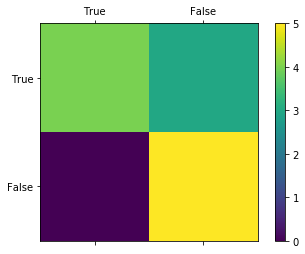

<function confusion_matrix at 0x7f65a4c00378>
(0.5583333333333333, 0.5833333333333334, 0.530812324929972, None)


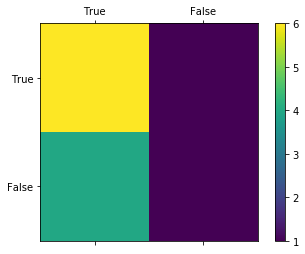

In [36]:
y_train, X_train = vector_for_learning(model_dbow, train_documents)
y_test, X_test = vector_for_learning(model_dbow, test_docs)

logreg = LogisticRegression(penalty='l1', n_jobs=1, verbose=True, solver='liblinear')
svm = SVC(probability=True, shrinking=False, random_state=42, gamma='auto')
svm.fit(X_train, y_train)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_svm = svm.predict(X_test)
print(f'Testing logreg accuracy events in HP: {accuracy_score(y_test, y_pred)}')
print(f'Testing logreg F1 score for events in HP: {f1_score(y_test, y_pred, average="weighted")}')

print(f'Testing svm accuracy events in HP: {accuracy_score(y_test, y_pred_svm)}')
print(f'Testing svm F1 score for events in HP: {f1_score(y_test, y_pred_svm, average="weighted")}')

      
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

labels = ['True', 'False']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_mat)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()
      
confusion_mat_svm = confusion_matrix(y_test, y_pred_svm)
print(confusion_matrix)

print(precision_recall_fscore_support(y_test, y_pred_svm, average='weighted'))

labels = ['True', 'False']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_mat_svm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()

In [41]:
dict_all_predictions = {}
with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
    chapter_numbers = json.load(chapter_numerated)

chapter_preds = {}
chapter_preprocessed = {}
with open('../data/chapters/chapter_paragraphs_unmerged.json', 'r',  encoding="utf8") as json_f:
    chapter_dict = json.load(json_f)
    for chapter, paragraphs in chapter_dict.items():
        ypreds = []
        ypreds_svm = []
        for par in paragraphs:
            preprocessed_par = preprocess_text(par)
            _, X_test = vector_for_learning(model_dbow, [TaggedDocument(words=preprocessed_par, tags=[-1])])
            ypreds.append(str(logreg.predict(X_test)[0]))
            ypreds_svm.append(str(svm.predict(X_test)[0]))
        chapter_preds[chapter] = {'text': paragraphs, 'class_logreg:': ypreds, 'class_svm':ypreds_svm}
        
with open('../data/events/predicted_events.json', 'w+') as outfile:  
    outfile.write(json.dumps(chapter_preds, indent=2))

In [79]:
with open('../data/events/predicted_events.json') as ev_json:
    events = json.load(ev_json)
final_events = pd.DataFrame(columns=['chapter_no', 'chapter_name', 'event_text'])
for chapter, sub_dict in events.items():
    values_logreg = sub_dict['class_logreg:']
    values_svm = sub_dict['class_svm']
    texts = sub_dict['text']
    events_per_col = {'chapter_no': chapter_numbers[chapter], 'chapter_name':chapter}
    event_texts = []
    for i in range(len(values_svm)):
        if values_svm[i] == values_logreg[i] == '1':
            event_texts.append(texts[i])
    events_per_col['event_text'] = event_texts
    final_events = final_events.append(events_per_col, ignore_index=True)

final_events = final_events.set_index(['chapter_no']).sort_index()
final_events.to_csv('../data/events/final_events.csv')